# Figure 3: Evo 2 likelihood as a function of gene age

**Purpose:** Analyze relationship between gene age and evolutionary likelihood  
**Output:** Time series plot with error bands showing gene age trends

## Setup and Configuration

In [ ]:
# Load required libraries and utility functions
suppressMessages(source("code/utils/utils.R"))

Custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' not found. Using fallback font 'sans'.


## Data Loading

Download and load gene ages

In [2]:
# Download
system('wget -O data/homo_sapiens_gene_ages.csv https://chenzxlab.hzau.edu.cn/static/GenOrigin/download/Age_Inference/Homo_sapiens.csv')

# Load gene age data
all_ages <- read.csv("data/homo_sapiens_gene_ages.csv")

print(paste("Gene age data loaded:", nrow(all_ages), "entries"))
print("First few rows of gene age data:")
print(head(all_ages))
print("Column names:")
print(colnames(all_ages))

[1] "Gene age data loaded: 23127 entries"
[1] "First few rows of gene age data:"
  ensembl_gene_id external_gene_name gene_age gene_Interval gene_branch
1 ENSG00000131188               PRR7      645       615-676          14
2 ENSG00000161055            SCGB3A1      244       177-312          20
3 ENSG00000280094              OR1B1        3           0-7          34
4 ENSG00000171501              OR1N2       18         16-20          31
5 ENSG00000239590              OR1J4       18         16-20          31
6 ENSG00000165202              OR1Q1       18         16-20          31
[1] "Column names:"
[1] "ensembl_gene_id"    "external_gene_name" "gene_age"          
[4] "gene_Interval"      "gene_branch"       


In [3]:
# Clean gene age formatting (remove '>' symbols)
all_ages$gene_age <- gsub(">", "", all_ages$gene_age)

print("Gene age range after cleaning:")
age_numeric <- as.numeric(all_ages$gene_age)
print(paste("Min age:", min(age_numeric, na.rm=TRUE), "MYA"))
print(paste("Max age:", max(age_numeric, na.rm=TRUE), "MYA"))
print(paste("Median age:", median(age_numeric, na.rm=TRUE), "MYA"))

[1] "Gene age range after cleaning:"
[1] "Min age: 3 MYA"
[1] "Max age: 4290 MYA"
[1] "Median age: 645 MYA"


Download human gene sequences

In [11]:
system('python3 code/utils/fig3_download_human_genes.py --gene_dir data/human_genes_dna')

Congifure parameters for calculating evo2 likelihoods

In [9]:
# Configuration 
API_KEY <- "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"
URL <- "https://health.api.nvidia.com/v1/biology/arc/evo2-40b/generate"
OUTPUT_DIR <- "data/evo2_output"
TEMP_DIR <- file.path(OUTPUT_DIR, "temp")
MAX_PARALLEL <- min(parallel::detectCores() - 1, 15)  # Use up to 15 cores or max available - 1
MAX_SEQ_LENGTH <- 300  # Shortened sequence length for faster API responses
TIMEOUT <- 60  # Timeout for API requests in seconds

# Create output directories
dir.create(OUTPUT_DIR, showWarnings = FALSE, recursive = TRUE)
dir.create(TEMP_DIR, showWarnings = FALSE, recursive = TRUE)

# Set working directory to project root
ROOT_DIR <- getwd()

# Get maximum number of parallel connections supported by R session
print(paste("Using", MAX_PARALLEL, "cores for parallel processing"))

[1] "Using 9 cores for parallel processing"


Calculate evo2 likelihoods in parallel

In [10]:
# Define the process_file function for parallel processing
process_file <- function(fasta_file) {
  return(get_evo2(fasta_file))
}

# Find all FASTA files
fasta_files <- list.files(path = file.path(ROOT_DIR, "data/human_genes_dna"), 
                          pattern = "\\.fa$", 
                          full.names = TRUE)

print(paste("Found", length(fasta_files), "FASTA files to process"))

# Option to limit the number of files for testing
# Comment out the next line for full processing
#fasta_files <- fasta_files[1:50]  # Process only the first 50 files for testing

print(paste("Will process", length(fasta_files), "files"))

# Process files in parallel
start_time <- Sys.time()

# Set up parallel cluster
cl <- makeCluster(MAX_PARALLEL)

# Export variables and functions to the cluster
clusterExport(cl, c("API_KEY", "URL", "TEMP_DIR", "MAX_SEQ_LENGTH", "TIMEOUT", "get_evo2", "process_file"))

# Load libraries on all workers
clusterEvalQ(cl, {
    library(httr)
    library(jsonlite)
    library(tools)
})

# Process files with progress bar
results <- pblapply(fasta_files, process_file, cl = cl)

# Stop the cluster
stopCluster(cl)

# Combine results into a data frame
results_df <- do.call(rbind, results)

# Calculate success and error counts
success_count <- sum(!grepl("ERROR", results_df$mean_likelihood))
error_count <- sum(grepl("ERROR", results_df$mean_likelihood))

elapsed_time <- Sys.time() - start_time
print(paste("Processing complete in", round(as.numeric(elapsed_time), 2), "seconds!"))
print(paste("Successfully processed:", success_count, "files"))
print(paste("Errors:", error_count, "files"))

# Save combined results to CSV
print("Combining results...")

write.csv(results_df, file.path(OUTPUT_DIR, "mean_likelihoods.csv"), row.names = FALSE)
print(paste("Results saved to", file.path(OUTPUT_DIR, "mean_likelihoods.csv")))

[1] "Found 22796 FASTA files to process"
[1] "Will process 22796 files"


[[1]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[8]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[9]]
 [1] "tools"     "jsonlite"  "httr"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

Load mean likelihoods

In [11]:
likelihoods <- read.csv("~/Documents/Research/github/2025-evo2-gene-age/output/mean_likelihoods.csv")

## Data Processing

Clean and prepare gene identifiers for matching

In [12]:
# Clean up gene identifiers (extract base gene ID before underscore)
original_ids <- likelihoods$gene_id[1:5]
likelihoods$gene_id <- unlist(lapply(strsplit(likelihoods$gene_id, "_"), function(x) x[1]))
cleaned_ids <- likelihoods$gene_id[1:5]

print("Gene ID cleaning example:")
print("Original IDs:")
print(original_ids)
print("Cleaned IDs:")
print(cleaned_ids)

print(paste("Total likelihood entries after cleaning:", length(unique(likelihoods$gene_id))))

[1] "Gene ID cleaning example:"
[1] "Original IDs:"
[1] "ENSG00000000003_15" "ENSG00000000005_6"  "ENSG00000000419_14"
[4] "ENSG00000000457_14" "ENSG00000000460_17"
[1] "Cleaned IDs:"
[1] "ENSG00000000003" "ENSG00000000005" "ENSG00000000419" "ENSG00000000457"
[5] "ENSG00000000460"
[1] "Total likelihood entries after cleaning: 22796"


## Data Integration

Match genes between datasets and extract corresponding values

In [13]:
# Identify genes present in both datasets
genes <- intersect(all_ages$ensembl_gene_id, likelihoods$gene_id)

print(paste("Genes in age dataset:", length(unique(all_ages$ensembl_gene_id))))
print(paste("Genes in likelihood dataset:", length(unique(likelihoods$gene_id))))
print(paste("Genes in both datasets:", length(genes)))

# Calculate overlap percentages
age_overlap <- round(100 * length(genes) / length(unique(all_ages$ensembl_gene_id)), 1)
lik_overlap <- round(100 * length(genes) / length(unique(likelihoods$gene_id)), 1)
print(paste("Overlap with age data:", age_overlap, "%"))
print(paste("Overlap with likelihood data:", lik_overlap, "%"))

[1] "Genes in age dataset: 23127"
[1] "Genes in likelihood dataset: 22796"
[1] "Genes in both datasets: 22710"
[1] "Overlap with age data: 98.2 %"
[1] "Overlap with likelihood data: 99.6 %"


In [22]:
# Match genes to their evolutionary ages
ages <- as.numeric(all_ages$gene_age[match(genes, all_ages$ensembl_gene_id)])

# Match genes to their likelihood values
liks <- as.numeric(likelihoods$mean_likelihood[match(genes, likelihoods$gene_id)])

print("Matched data summary:")
print(paste("Valid age values:", sum(!is.na(ages))))
print(paste("Valid likelihood values:", sum(!is.na(liks))))
print(paste("Complete pairs:", sum(!is.na(ages) & !is.na(liks))))

Warning message:
"NAs introduced by coercion"


[1] "Matched data summary:"
[1] "Valid age values: 22710"
[1] "Valid likelihood values: 22700"
[1] "Complete pairs: 22700"


## Rolling Window Analysis

Calculate rolling averages across evolutionary time using 250 MYA windows

In [15]:
# Calculate rolling averages across evolutionary time
bins <- list()
window_size <- 250
step_size <- 1

print(paste("Calculating rolling windows with", window_size, "MYA windows, step size:", step_size))
print("Processing time windows...")

for (i in seq(1, 1500, step_size)) {
  if (i %% 100 == 1) print(paste("Processing window starting at", i, "MYA"))
  
  # Extract log-likelihood values for 250 MYA windows
  x <- log(liks[ages > i & ages < (i + window_size)]) * -1
  bins[[as.character(i)]] <- x
}

print(paste("Created", length(bins), "time windows"))

# Show window sizes
window_sizes <- unlist(lapply(bins, length))
print(paste("Window size range:", min(window_sizes), "to", max(window_sizes), "genes"))
print(paste("Median window size:", median(window_sizes), "genes"))

[1] "Calculating rolling windows with 250 MYA windows, step size: 1"
[1] "Processing time windows..."
[1] "Processing window starting at 1 MYA"
[1] "Processing window starting at 101 MYA"
[1] "Processing window starting at 201 MYA"
[1] "Processing window starting at 301 MYA"
[1] "Processing window starting at 401 MYA"
[1] "Processing window starting at 501 MYA"
[1] "Processing window starting at 601 MYA"
[1] "Processing window starting at 701 MYA"
[1] "Processing window starting at 801 MYA"
[1] "Processing window starting at 901 MYA"
[1] "Processing window starting at 1001 MYA"
[1] "Processing window starting at 1101 MYA"
[1] "Processing window starting at 1201 MYA"
[1] "Processing window starting at 1301 MYA"
[1] "Processing window starting at 1401 MYA"
[1] "Created 1500 time windows"
[1] "Window size range: 343 to 7532 genes"
[1] "Median window size: 2191 genes"


## Statistical Summary

Calculate median and standard error for each time window

In [16]:
# Calculate median and standard error for each time window
roll_m <- unlist(lapply(bins, function(x) median(x, na.rm = TRUE)))
roll_error_m <- unlist(lapply(bins, function(x) pracma::std_err(na.omit(x))))

print("Rolling statistics summary:")
print(paste("Valid median values:", sum(!is.na(roll_m))))
print(paste("Valid error values:", sum(!is.na(roll_error_m))))

print("Median negative log-likelihood range:")
print(paste("Min:", round(min(roll_m, na.rm=TRUE), 3)))
print(paste("Max:", round(max(roll_m, na.rm=TRUE), 3)))
print(paste("Mean:", round(mean(roll_m, na.rm=TRUE), 3)))

print("Standard error range:")
print(paste("Min:", round(min(roll_error_m, na.rm=TRUE), 4)))
print(paste("Max:", round(max(roll_error_m, na.rm=TRUE), 4)))
print(paste("Mean:", round(mean(roll_error_m, na.rm=TRUE), 4)))

[1] "Rolling statistics summary:"
[1] "Valid median values: 1500"
[1] "Valid error values: 1500"
[1] "Median negative log-likelihood range:"
[1] "Min: 0.055"
[1] "Max: 0.112"
[1] "Mean: 0.074"
[1] "Standard error range:"
[1] "Min: 0.0039"
[1] "Max: 0.019"
[1] "Mean: 0.0086"


## Visualization Data Preparation

In [21]:
# Prepare data frame for plotting
val <- data.frame(x = seq(1, 1500, 1),
                 y = roll_m,
                 error = roll_error_m)

# Remove any rows with missing values
val_clean <- val[complete.cases(val), ]

## Plot Generation

Create time series plot with confidence bands

[1] "Time series plot generated"


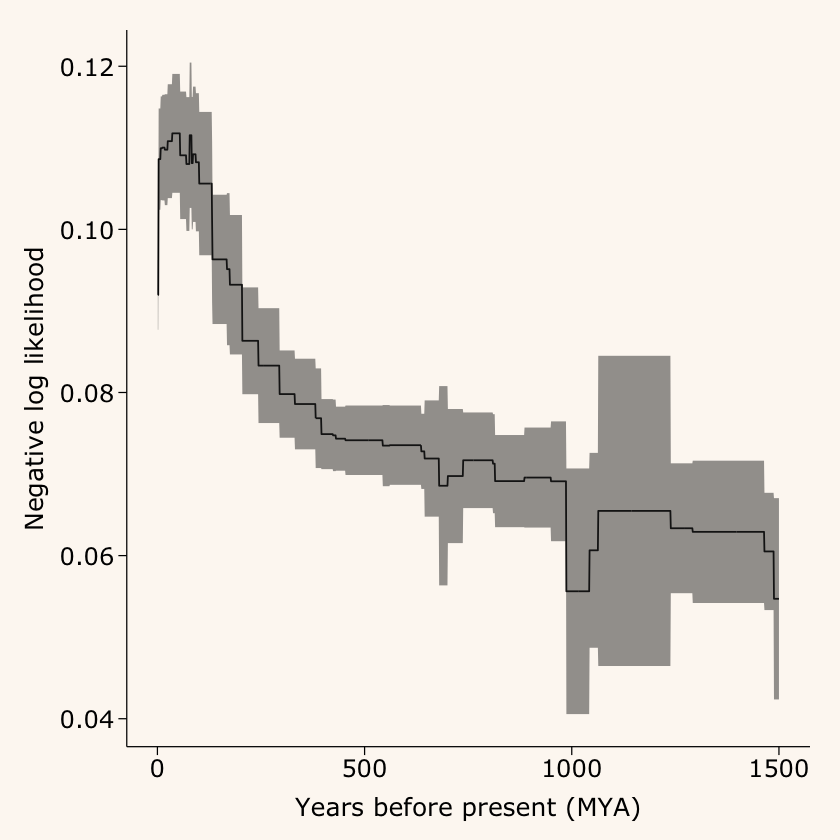

In [18]:
# Create time series plot with confidence bands
p <- ggplot(data = val,
       aes(x = x,
           y = y,
           ymin = y - roll_error_m,
           ymax = y + roll_error_m)) +
  geom_line() +
  geom_ribbon(alpha = 0.5) +
  theme_arcadia() +
  xlab("Years before present (MYA)") +
  ylab("Negative log likelihood")

# Display the plot
print(p)

print("Time series plot generated")

## Correlation Analysis

Calculate correlation between evolutionary time and likelihood

In [19]:
# Calculate correlation between time and likelihood
correlation <- cor(val$x, val$y, use = "complete.obs")

print(paste("Correlation between time (MYA) and negative log-likelihood:", round(correlation, 4)))

# Additional correlation statistics
cor_test <- cor.test(val$x, val$y, use = "complete.obs")
print(paste("P-value:", format.pval(cor_test$p.value, digits = 3)))
print(paste("95% Confidence interval:", 
           round(cor_test$conf.int[1], 4), "to", round(cor_test$conf.int[2], 4)))

[1] "Correlation between time (MYA) and negative log-likelihood: -0.8623"


[1] "P-value: <2e-16"
[1] "95% Confidence interval: -0.8747 to -0.8487"


## Conclusion

This analysis:
1. Integrated gene age data from OrthoDB with evolutionary likelihood estimates
2. Applied rolling window analysis across evolutionary time (250 MYA windows)
3. Calculated median likelihood values and standard errors for each time period
4. Visualized temporal trends with confidence bands
5. Quantified the relationship between gene age and evolutionary likelihood

The results reveal how evolutionary likelihood patterns change across different evolutionary time scales, providing insights into the relationship between gene age and evolutionary processes.